In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/processed/creditcard_cleaned.csv")
X = df.drop("Class", axis=1)
y = df["Class"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Original class distribution:\n", y_train.value_counts())


Original class distribution:
 Class
0    227451
1       394
Name: count, dtype: int64


In [4]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print("\nAfter SMOTE:\n", pd.Series(y_resampled).value_counts())



After SMOTE:
 Class
0    227451
1    227451
Name: count, dtype: int64


In [5]:
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)


In [6]:
ensemble = VotingClassifier(
    estimators=[("lr", lr), ("rf", rf), ("xgb", xgb)],
    voting="soft"
)

In [7]:
ensemble.fit(X_resampled, y_resampled)

# Predictions
preds = ensemble.predict(X_test)
proba = ensemble.predict_proba(X_test)[:, 1]

/home/foxtech/SHAHROZ_PROJ/Credit_Card_fraud_detection/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:18:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [8]:
print("\n📊 Classification Report (Ensemble w/ SMOTE):\n")
print(classification_report(y_test, preds, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, proba))


📊 Classification Report (Ensemble w/ SMOTE):

              precision    recall  f1-score   support

           0     0.9998    0.9994    0.9996     56864
           1     0.7167    0.8776    0.7890        98

    accuracy                         0.9992     56962
   macro avg     0.8582    0.9385    0.8943     56962
weighted avg     0.9993    0.9992    0.9992     56962

ROC-AUC Score: 0.974202142168066


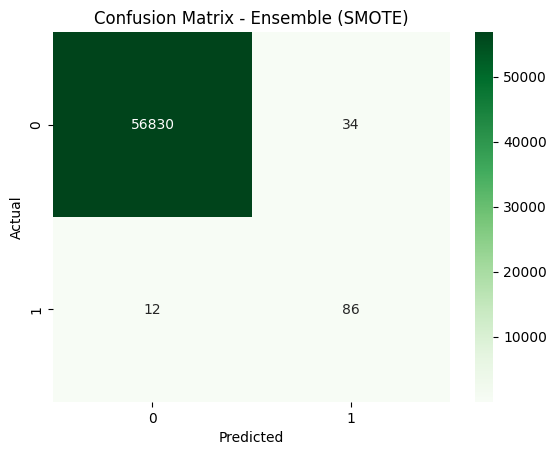

In [9]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Ensemble (SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()